In [1]:
from jqdatasdk import *
auth('15051871508','871508')

auth success 


In [2]:
import numpy as np
import pandas as pd

In [3]:
index_df = get_bars('000300.XSHG',36,unit='1d',fields=['date','close'],end_dt = '2019-03-01')
# index_df = get_bars('000300.XSHG',57,unit='1d',fields=['date','close'],end_dt = '2019-3-30')

E:\Miniconda\lib\pickle.py:1423: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  __import__(module, level=0)


In [4]:
dates = index_df['date'].drop(13)
dates = dates.reset_index(drop=True)

In [5]:
# df_big_buy = pd.read_csv('buysell_bigsell.csv')
df_big_buy = pd.read_csv('buyAndSellFinal_bigsell.csv')
df_big_buy.set_index(['time'],inplace=True)

In [6]:
# df_big_sell = pd.read_csv('buysell_bigbuy.csv')
df_big_sell = pd.read_csv('buyAndSellFinal_bigbuy.csv')
df_big_sell.set_index(['time'],inplace=True)

In [7]:
df_daily_close = pd.read_csv('day_close.csv')
df_daily_close.set_index(['time'],inplace=True)

In [8]:
df_daily_open = pd.read_csv('day_open.csv')
df_daily_open.set_index(['time'],inplace=True)

In [9]:
list_of_stocks = list(get_all_securities(types=['stock'], date='2019-02-02').index)

In [10]:
list_of_stocks_drop_latter_str = [stock_name[:-5] for stock_name in list_of_stocks]

In [11]:
stock_list_after_data_cleaning =list(set(df_big_buy.columns) & set(list_of_stocks_drop_latter_str))

In [12]:
df_big_buy_after_data_cleaning = df_big_buy.loc[:,stock_list_after_data_cleaning]

In [13]:
df_big_sell_after_data_cleaning = df_big_sell.loc[:,stock_list_after_data_cleaning]

In [14]:
df_daily_close_after_data_cleaning = df_daily_close.loc[list(df_big_buy.index),stock_list_after_data_cleaning]
df_daily_open_after_data_cleaning = df_daily_open.loc[list(df_big_buy.index),stock_list_after_data_cleaning]

In [15]:
df_daily_close_minus_open_return_after_data_cleaning=(df_daily_close_after_data_cleaning-df_daily_open_after_data_cleaning)/df_daily_open_after_data_cleaning

In [16]:
df_daily_return_after_data_cleaning=df_daily_close_after_data_cleaning.apply(lambda x: x.pct_change())

In [17]:
factor_big_buy_ratio = df_big_buy_after_data_cleaning
factor_big_sell_ratio = df_big_sell_after_data_cleaning
factor_big_buy_minus_big_sell = factor_big_buy_ratio-factor_big_sell_ratio
factor_big_order_ratio = factor_big_buy_ratio+factor_big_sell_ratio

In [18]:
df_big_sell_after_data_cleaning.iloc[1,:].sort_values(ascending = False).index

Index(['600423', '600518', '600027', '600098', '600088', '600083', '600731',
       '601999', '600790', '600565',
       ...
       '600030', '601975', '601298', '603700', '601598', '601615', '603121',
       '600774', '603351', '603332'],
      dtype='object', length=1449)

In [19]:
import math
strategy_daily_yeild_list = []
daily_ordered_stock_return_list = []
classification_return_1 = []
classification_return_2 = []
classification_return_3 = []
classification_return_4 = []
classification_return_5 = []
classification_return_6 = []
classification_return_7 = []
classification_return_8 = []
classification_return_9 = []
classification_return_10 = []
classification_return_index = [classification_return_1,classification_return_2,classification_return_3,classification_return_4,classification_return_5,classification_return_6,classification_return_7,classification_return_8,classification_return_9,classification_return_10]
for date_index,value in factor_big_buy_minus_big_sell.iterrows():
    if date_index == factor_big_buy_minus_big_sell.index[0]:
        print('跳')
    else:
        print(date_index)
        daily_ordered_stock_return_list.append(df_daily_return_after_data_cleaning.loc[date_index,max_factor_stock_list])
        
        tradable_stocks =max_factor_stock_list;
        for i in range(10):
            start = i*math.ceil(len(tradable_stocks)/10)
            end = min((i+1)*math.ceil(len(tradable_stocks)/10),len(tradable_stocks)-1)
            classed_stocks = tradable_stocks[start:end]
            mean_value = (np.nanmean(df_daily_return_after_data_cleaning.loc[date_index,classed_stocks]))*(1)-0.001
#             print(mean_value)
            classification_return_index[i].append(mean_value)
     
        
        
#         max_factor_stock_list = max_factor_stock_list[:10]
        joinquant_code_list = [ stock+'.XSHG' for stock in max_factor_stock_list]
        q = query(
            valuation
        ).filter(
            valuation.code.in_(joinquant_code_list),
            valuation.market_cap>500
        )
        df = get_fundamentals(q, str(date_index)[0:4]+'-'+str(date_index)[4:6]+'-'+str(date_index)[6:])
        big_market_cap_stock_list = list(df['code'])
        
        big_and_max_factor_stock_list = []
        for stock in max_factor_stock_list:
            if stock+'.XSHG' in big_market_cap_stock_list:
                big_and_max_factor_stock_list.append(stock)
                if len(big_and_max_factor_stock_list)==10:
                    print(big_and_max_factor_stock_list)
                    break
                
                
        max_factor_stock_list =big_and_max_factor_stock_list
        
# 打印出总市值
#         print(str(date_index)[0:4]+'-'+str(date_index)[4:6]+'-'+str(date_index)[6:])
#         print(df['market_cap'])
        strategy_daily_yeild_list.append((df_daily_return_after_data_cleaning.loc[date_index,max_factor_stock_list].mean())*(1-0.001))
#         print(date_index)
#         print(max_factor_stock_list)
    max_factor_stock_list = list(value.sort_values(ascending = False).index)
    
    ##删除涨停股    
    stock_list = []
    
    for stock in max_factor_stock_list:
        if not df_daily_close_after_data_cleaning.loc[date_index,stock]== df_daily_open_after_data_cleaning.loc[date_index,stock]:
            if not np.isnan(df_daily_close_after_data_cleaning.loc[date_index,stock]):
                stock_list.append(stock)
#             print(date_index,stock,'涨停,无法买入')
    
    
    max_factor_stock_list = stock_list
    
    ####删除涨停股票
    

    
        
    
#     strategy_daily_yeild_list.append((df_daily_return_after_data_cleaning.loc[date_index,max_factor_stock_list].mean())*(1-0.1))
    

跳
20190103
['601225', '600741', '600346', '600023', '601669', '601138', '600340', '601006', '600406', '601989']
20190104
['600016', '600900', '600837', '601006', '601766', '601818', '600919', '600028', '601899', '601989']
20190107
['601669', '601818', '601727', '601989', '600346', '600025', '601288', '601881', '601066', '601166']
20190108
['600025', '600029', '601727', '601012', '601633', '601006', '601998', '600346', '600028', '601225']
20190109
['601166', '600025', '601933', '600886', '600000', '601888', '600276', '600919', '601688', '601766']
20190110
['601398', '600029', '600309', '600606', '601138', '601328', '601169', '600036', '601288', '601009']
20190111
['600023', '600346', '600900', '601318', '601998', '600016', '600919', '600893', '600886', '600115']
20190114
['601336', '601225', '601111', '601888', '600029', '601633', '600048', '600346', '600115', '601319']
20190115
['601998', '600377', '601991', '601877', '600346', '600000', '601225', '600031', '601766', '600340']
20190116

In [20]:
ic_list = []
for series in daily_ordered_stock_return_list:
    y = -series.argsort()
    ic_list.append(np.corrcoef(y.values,np.array(range(1,len(y.values)+1)))[0][-1])
    

In [21]:
np.mean(ic_list)

0.1008345983841863

E:\Miniconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


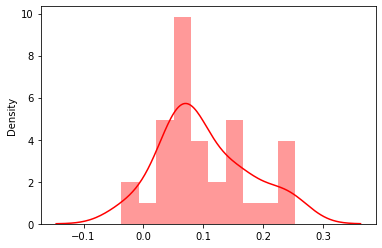

In [23]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
# n, bins, patches = plt.hist(ic_list,8,histtype='stepfilled',facecolor='b',alpha=0.75)#40表示在生成的图形中直方的个数，normed=1是归一后出现的概率。normed=0表示出现的次数
# plt.title('Histogram')
import seaborn as sns 
sns.set_palette("hls") #设置所有图的颜色，使用hls色彩空间
sns.distplot(ic_list,color="r",bins=10,kde=True)
plt.show()


In [24]:
cum_strategy = np.cumprod([i+1 for i in strategy_daily_yeild_list])
cum_strategy = [i-1 for i in cum_strategy]

In [25]:
cum_strategy1 = np.cumprod([i+1 for i in classification_return_1])
cum_strategy1 = [i-1 for i in cum_strategy1]
cum_strategy2 = np.cumprod([i+1 for i in classification_return_2])
cum_strategy2 = [i-1 for i in cum_strategy2]
cum_strategy3 = np.cumprod([i+1 for i in classification_return_3])
cum_strategy3 = [i-1 for i in cum_strategy3]
cum_strategy4 = np.cumprod([i+1 for i in classification_return_4])
cum_strategy4 = [i-1 for i in cum_strategy4]
cum_strategy5 = np.cumprod([i+1 for i in classification_return_5])
cum_strategy5 = [i-1 for i in cum_strategy5]
cum_strategy6 = np.cumprod([i+1 for i in classification_return_6])
cum_strategy6 = [i-1 for i in cum_strategy6]
cum_strategy7 = np.cumprod([i+1 for i in classification_return_7])
cum_strategy7 = [i-1 for i in cum_strategy7]
cum_strategy8 = np.cumprod([i+1 for i in classification_return_8])
cum_strategy8 = [i-1 for i in cum_strategy8]
cum_strategy9 = np.cumprod([i+1 for i in classification_return_9])
cum_strategy9 = [i-1 for i in cum_strategy9]
cum_strategy10 = np.cumprod([i+1 for i in classification_return_10])
cum_strategy10= [i-1 for i in cum_strategy10]

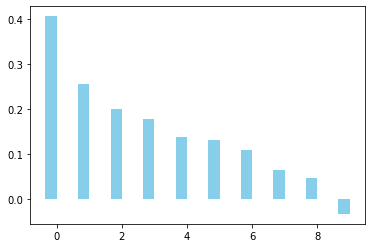

In [27]:

men_means= (20, 35, 30, 35, 27,20, 35, 30, 35, 27)

 
ind = np.arange(len(men_means))  # the x locations for the groups
width = 0.35  # the width of the bars
 
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, [cum_strategy1[-1],cum_strategy2[-1],cum_strategy3[-1],cum_strategy4[-1],cum_strategy5[-1],cum_strategy6[-1],cum_strategy7[-1],cum_strategy8[-1],cum_strategy9[-1],cum_strategy10[-1]], width, color='SkyBlue', label='Men')

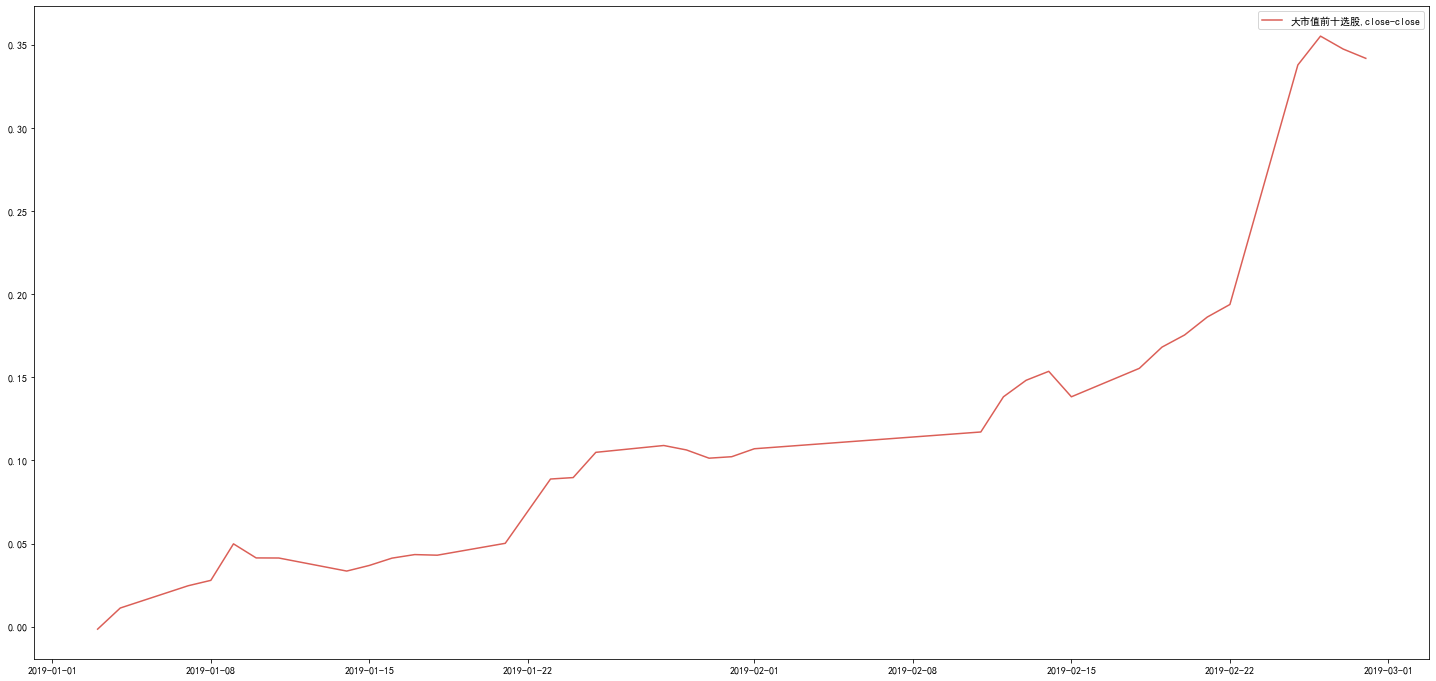

In [28]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
fig, ax = plt.subplots(figsize=(25, 12))
ax.plot(dates,cum_strategy,label = '大市值前十选股,close-close')
# ax.plot(dates,cum_strategy,label = '最后一组纯空')
# ax.plot(dates,cum_strategy1,label = '第一组')
# ax.plot(dates,cum_strategy2,label = '第二组')


# ax.plot(dates,cum_strategy3,label = '第三组')


# ax.plot(dates,cum_strategy4,label = '第四组')


# ax.plot(dates,cum_strategy5,label = '第五组')
# ax.plot(dates,cum_strategy6,label = '第六组')


# ax.plot(dates,cum_strategy7,label = '第七组')


# ax.plot(dates,cum_strategy8,label = '第八组')


# ax.plot(dates,cum_strategy9,label = '第九组')


# ax.plot(dates,cum_strategy10,label = '第十组')

ax.legend()



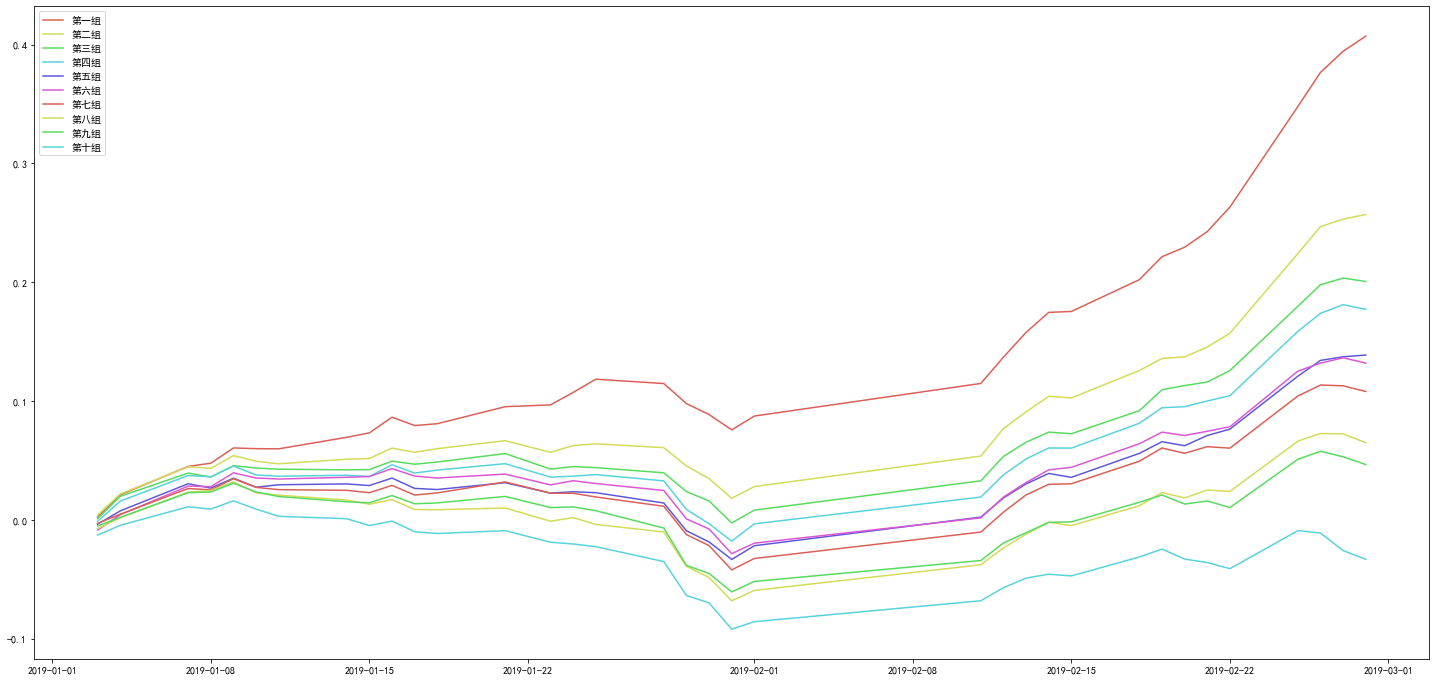

In [29]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
fig, ax = plt.subplots(figsize=(25, 12))
# ax.plot(dates,cum_strategy,label = '大市值前十选股,close-close')
# ax.plot(dates,cum_strategy,label = '最后一组纯空')
ax.plot(dates,cum_strategy1,label = '第一组')
ax.plot(dates,cum_strategy2,label = '第二组')


ax.plot(dates,cum_strategy3,label = '第三组')


ax.plot(dates,cum_strategy4,label = '第四组')


ax.plot(dates,cum_strategy5,label = '第五组')
ax.plot(dates,cum_strategy6,label = '第六组')


ax.plot(dates,cum_strategy7,label = '第七组')


ax.plot(dates,cum_strategy8,label = '第八组')


ax.plot(dates,cum_strategy9,label = '第九组')


ax.plot(dates,cum_strategy10,label = '第十组')

ax.legend()

